In [36]:
#region Chargement des packages
#from IPython import get_ipython;
#get_ipython().magic('reset -sf')
import os
import sys
if os.path.basename(os.getcwd())=='Prospective_conso':
    sys.path.append('../../')
from functions.f_notebook import hide_toggle
import pandas as pd
from functions.f_tools import *
from functions.f_graphicalTools import *
from Models.Prospective_conso.f_evolution_tools import *
from mycolorpy import colorlist as mcp
import numpy as np
import time
from plotnine import *
from functools import reduce
dpe_colors = ['#009900', '#33cc33', '#B3FF00', '#e6e600', '#FFB300', '#FF4D00', '#FF0000',"#000000"]

# print(os.getcwd())
Graphic_folder = "Graphics/"
Data_folder = "data/"
# endregion

# Tertiary building stock evolution

## *Defining an initial configuration and energy retrofit pathways*

### Table of Contents

* [1. Introduction](#intro)
* [2. Initial state of the building stock](#initialstate)
* [3. Decarbonization of building stock heating](#decarbonization)
    * [3.1 An example path towards emission reduction ](#firstpath)
    * [3.2 Achieving SNBC objectives through electrification](#electrification)
    * [3.3 Technical constraints and alternative paths](#alternatives)
* [4. Input data structure](#inputdata)


## 1. Introduction <a class="anchor" id="intro"></a>

This notebook will guide you through the undersanding of the heating demand in french residential and tertiary sectors. First of all, a basic representation of the building stock is used to characterise the initial state of the buildings and heating systems. Then, different modification can be applied to this initial situation in order to draw paths towards 2050, with the aim of reducing carbon emissions.not

This guided work shall permit you to draw yourself some paths towards a cleaner future for building heating sector, considering technical and temporal constraints.

The scope of this work is Metropolitan France and all the data used in this work are extracted from french governemental institutions, such as ADEME, SDES, INSEE...

## 2. Initial state of the building stock <a class="anchor" id="initialstate"></a>

First and foremost, we load the input data, stored in an excel file. More detail on the input structure and content can be found in [Section 4](#inputdata). These input data are extracted from the different sheets and stored in sim_param dictionnary.

In [37]:
#Four dimensions in the dataset
dim_names = ["Energy_source", "building_type", "Vecteur", "year"];
#Two main indexes
Index_names = ["Energy_source", "building_type"];
Energy_system_name = "Energy_source"
#Reading the data
data_set_from_excel = pd.read_excel(Data_folder + "Hypotheses_residential_tertiary_BASIC.xlsx", None);
#Extracting info from sheets and creating indexes etc
sim_param = extract_sim_param(data_set_from_excel, Index_names=Index_names, dim_names=dim_names,
                              Energy_system_name=Energy_system_name)
#Creating the initial building description
sim_param["init_sim_stock"] = create_initial_parc(sim_param).sort_index()
sim_param["volume_variable_name"] = "surface"
sim_param["init_sim_stock"]["surface"] = sim_param["init_sim_stock"]["surface"] * sim_param["init_sim_stock"]["IPONDL"]
sim_param_copy4plot=sim_param.copy()

The initial state of French building stock can be summarized and vizualized ploting a few graphs. Fot this, we gather all the info in a single dataframe (emission factors, efficiencies, etc.).

Conso totale :375.0 TWh et conso d'élec :46.0 TWh


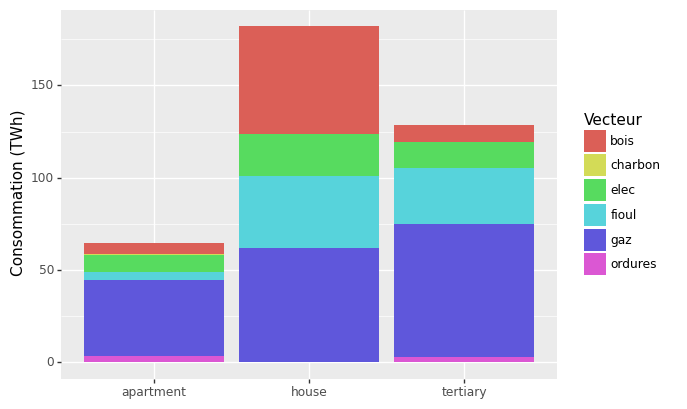

In [38]:
# region plot data shaping
init_stock=sim_param_copy4plot["init_sim_stock"].copy()


init_stock=init_stock.drop(['IPONDL'],axis=1)
init_stock=pd.melt(init_stock,id_vars=['proportion_energy_need','energy_need_per_surface','surface'],value_name='conso_unitaire',ignore_index=False)
init_stock[['v1','v2','Vecteur']]=init_stock['variable'].str.split('_',expand=True)
init_stock=init_stock.drop(['v1','v2','variable'],axis=1)
init_stock=init_stock.reset_index()
init_stock=init_stock[init_stock['conso_unitaire'] > 0]

# We adjust energy need for electricity considering the primary energy factor
init_stock["energy_need_per_surface"]=init_stock["energy_need_per_surface"]/((init_stock["Vecteur"]=="elec") * 1.58 + 1)
init_stock=init_stock.set_index(["Energy_source", "building_type", "Vecteur"])

data_frames=[init_stock,sim_param_copy4plot['seasonal_efficiency'],sim_param_copy4plot['peak_efficiency'],sim_param_copy4plot['direct_emissions'],sim_param_copy4plot['indirect_emissions']]

init_stock = reduce(lambda  left,right: pd.merge(left,right,
                                            left_index=True,right_index=True), data_frames)

init_stock=init_stock.reset_index().set_index(["Energy_source", "building_type", "Vecteur"])
init_stock['Besoin']=init_stock['proportion_energy_need']*init_stock['energy_need_per_surface']*init_stock['surface']*init_stock['conso_unitaire']/10**9
init_stock['Consumption']=init_stock['Besoin']/init_stock['seasonal_efficiency']
init_stock['Emissions']=init_stock['Consumption']*(init_stock['indirect_emissions']+init_stock['direct_emissions'])/10**3

initial_need=init_stock['Besoin'].sum()
initial_emissions=init_stock['Emissions'].sum()
initial_consumption=init_stock['Consumption'].sum()
# endregion
print("Conso totale :"+str(round(init_stock.Consumption.sum(),0))+ " TWh et conso d'élec :"+
      str(round(init_stock.loc[(slice(None),slice(None),"elec"),"Consumption"].sum(),0))+" TWh")

## Drawing the energy consumption by energy vector
forplot=init_stock.groupby(['building_type','Vecteur']).agg('sum').reset_index()
fig=(
    ggplot(forplot)+
    geom_col(aes(x='building_type',y="Consumption",fill='Vecteur'))+
    ylab("Consommation (TWh)")+
    xlab('')
)
p = fig.draw()

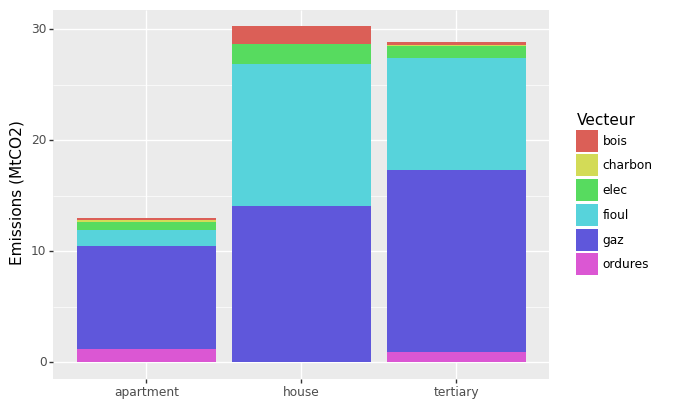

In [39]:
## Drawing the CO2 emissions by energy vector
fig=(
    ggplot(forplot)+
    geom_col(aes(x='building_type',y="Emissions",fill='Vecteur'))+
    ylab("Emissions (MtCO2)")+
    xlab('')
)
p = fig.draw()

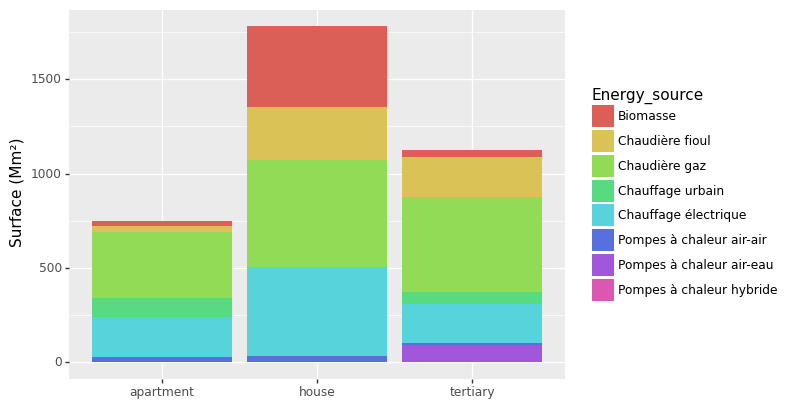

In [40]:
## Drawing the energy surface by energy source
forplot2=init_stock.groupby(['Energy_source','building_type'])["surface"].agg('mean').reset_index().filter(['Energy_source','building_type','surface','Consumption','Emissions'])
forplot2["surface"]=forplot2["surface"]/10**6

fig=(
    ggplot(forplot2)+
    geom_col(aes(x='building_type',y="surface",fill='Energy_source'))+
    ylab("Surface (Mm²)")+
    xlab('')
)
p = fig.draw()

We can see that GHG emissions mainly come from gas an fuel, as electricity and wood have a low emission factor. Replacing the heating systems burning such fuels is thus the priority. Also, heating network are mainly used in apartments and teritary buildings.

For the electricity peak, knowing that the actual residential electricity demand (about 35 TWh) represent a thermosensitivity of 1.5kW/°C (based on Enedis observations), we can estimate the global thermosensitivity due to electric heating in the residential and tertiary sectors.

In [41]:
init_stock_init=init_stock.copy().reset_index()
init_stock_init=init_stock_init[init_stock_init["Vecteur"]=='elec']
themosensitivity=np.sum(init_stock_init['Consumption']*1.5/35/init_stock_init['peak_efficiency'])
print(themosensitivity)

1.9429504504813717


The peak electricity demand can thus be estimated by calculating the peak power at a very cold temperature (typically -5°C). Compare this value with French installed power capacity.

In [42]:
T_base=-5
peak_power=themosensitivity*(15-T_base)
peak_power

38.859009009627435

## 3. Decarbonization of building stock heating <a class="anchor" id="decarbonization"></a>
For drawing the scenarios towards 2050, some pre-processing is needed to interpolathe the evolution of some parameters indexed along year.

In [43]:
sim_param = interpolate_sim_param(sim_param)
sim_param["retrofit_change_surface"]=sim_param["retrofit_change_total_proportion_surface"].diff().fillna(0)

Para_2_fill = {param: sim_param["base_index_year"] for param in
               ["retrofit_improvement", "retrofit_change_surface", "retrofit_Transition"]}
sim_param = complete_parameters(sim_param, Para_2_fill=Para_2_fill)
sim_param["retrofit_change_surface"]=sim_param["retrofit_change_surface"]*sim_param["init_sim_stock"]["surface"]

sim_param = complete_missing_indexes(data_set_from_excel, sim_param, Index_names, dim_names)


We define some functions which will permit to estimate all the indicators, year by year. The three indicators we monitor are energy consumption, GHG emissions and electricity peak The heating need and final consumption are then calculated for each energy_source.

In [44]:
def f_Compute_conso(x,sim_param,Vecteur):
    conso_unitaire = x["conso_unitaire_"+Vecteur]
    Energy_source = x.name[sim_param['base_index'].names.index('Energy_source')]
    seasonal_efficiency=sim_param["seasonal_efficiency"][(Energy_source,Vecteur)]
    conso_unitaire=conso_unitaire/seasonal_efficiency
    return x["energy_need_per_"+sim_param["volume_variable_name"]] * x[sim_param["volume_variable_name"]]*x["proportion_energy_need"]*conso_unitaire
def f_Compute_conso_totale(x,sim_param):
    res=0.
    for Vecteur in sim_param["Vecteurs"]:
        res+=x["conso_"+Vecteur]
    return res

#
for Vecteur in sim_param["Vecteurs"]:
    sim_param["f_Compute_conso_"+Vecteur]={"conso_"+Vecteur : partial(f_Compute_conso,Vecteur =Vecteur)}
sim_param["f_Compute_conso_totale"]={"Conso" : lambda x,sim_param: f_Compute_conso_totale(x,sim_param)}

def f_Compute_besoin(x,sim_param): return x["energy_need_per_surface"] * x["surface"]*x["proportion_energy_need"]
sim_param["f_Compute_besoin"]={"Besoin" : f_Compute_besoin}

def f_compute_emissions(x, sim_param, year, Vecteur):
    return sim_param["direct_emissions"].loc[Vecteur, year] * x["conso_" + Vecteur] + \
           sim_param["indirect_emissions"].loc[Vecteur, year] * x["conso_" + Vecteur]

def f_Compute_emissions_totale(x, sim_param):
    res = 0.
    for Vecteur in sim_param["Vecteurs"]:
        res += x["emissions_" + Vecteur]
    return res

for Vecteur in sim_param["Vecteurs"]:
    sim_param["f_Compute_emissions_"+Vecteur]={"emissions_"+Vecteur : partial(f_compute_emissions,Vecteur =Vecteur)}
sim_param["f_Compute_emissions_totale"]={"emissions" : lambda x,sim_param: f_Compute_emissions_totale(x,sim_param)}

def f_Compute_electrical_peak(x, sim_param):
    Energy_source = x.name[sim_param['base_index'].names.index('Energy_source')]
    return x["conso_elec"] * 1.5 / 35  / sim_param["peak_efficiency"][(Energy_source,"elec")]
sim_param["f_Compute_electrical_peak_totale"] = {
    "electrical_peak": lambda x, sim_param: f_Compute_electrical_peak(x, sim_param)}

The retrofit scenario is defined by two elements:
1. The retrofit transition matrix: defines the switch from one heating system to another
2. The thermal retrofit savings: defines in what extent the energy need is reduced when buildings are retrofitted

In [45]:
#Transition matrix for apartments
b_type="apartment"
transition_matrix=sim_param['retrofit_Transition'].copy().rename_axis(columns=None).reset_index()
transition_matrix.loc[(transition_matrix["year"]==2020) & (transition_matrix["building_type"]==b_type)].drop([\
                                        "old_new","building_type","year"],axis=1).set_index('Energy_source').transpose()

Energy_source,Biomasse,Chaudière fioul,Chaudière gaz,Chauffage urbain,Chauffage électrique,Pompes à chaleur air-air,Pompes à chaleur air-eau,Pompes à chaleur hybride
Biomasse,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Chaudière fioul,0.037922,0.0,0.000000,0.150208,0.000000,0.090828,0.721041,0.0
Chaudière gaz,0.036064,0.0,0.176909,0.151599,0.000000,0.064450,0.569147,0.0
Chauffage urbain,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
Chauffage électrique,0.031719,0.0,0.000000,0.158977,0.295539,0.513765,0.000000,0.0
Pompes à chaleur air-air,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.0
Pompes à chaleur air-eau,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
Pompes à chaleur hybride,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [46]:
retrofit_improvement=sim_param['retrofit_improvement'].copy().reset_index()
retrofit_improvement.loc[(retrofit_improvement["Energy_source"]=="Biomasse") & (retrofit_improvement["building_type"]=="apartment")]\
                                        .drop(['Energy_source','building_type'],axis=1).set_index("year")

,retrofit_improvement
year,
2020,0.200
2021,0.205
2022,0.210
2023,0.215
2024,0.220
2025,0.225
2026,0.230
2027,0.235
2028,0.240


Let's now look at the first scenario results. We first initiate the simulation.


### 3.1 An example path towards emission reduction <a class="anchor" id="firstpath"></a>
Considering all the inputs described above, we can launch the simulation of the scenario. The simulation function calculates the surface to be retrofitted each year, the energy need of the surface after retrofit and the energy_source which will provide the energy_need and the switches from one energy source to another.

In [47]:
sim_stock = launch_simulation(sim_param)

Computing: [########################################] 29/29



We collect the output data into a dataframe we can exploit to do some plot and analysis.

In [48]:
sim_stock_df = pd.concat(sim_stock, axis=0).reset_index().\
    rename(columns={"level_0":"year"}).set_index([ "year"  ,  "Energy_source"  , "old_new"])

Here comes the evolution of energy needs of buildings, splitted by building type.

In [49]:
Var = "Besoin"
y_df = sim_stock_df.groupby(["year", "building_type"])[Var].sum().to_frame().reset_index(). \
           pivot(index=['year'], columns='building_type').loc[[year for year in sim_param["years"][1:]], Var] / 10 ** 9
fig = MyStackedPlotly(y_df=y_df)
fig = fig.update_layout(title_text="Besoin d'énergie de chauffage par vecteur énergétique (en TWh)", xaxis_title="Année",
                        yaxis_title="Besoin [TWh]")
fig.show()

But it is also possible to plot the evolution of energy consumption or GHG emissions due to heating.

In [50]:
Var = "Conso"
y_df = sim_stock_df.groupby(["year", "Energy_source"])[Var].sum().to_frame().reset_index(). \
           pivot(index=['year'], columns='Energy_source').loc[[year for year in sim_param["years"][1:]], Var] / 10 ** 9
fig = MyStackedPlotly(y_df=y_df)
fig = fig.update_layout(title_text="Conso d'énergie par mode de chauffage (en TWh)", xaxis_title="Année",
                        yaxis_title="Consommation [TWh]")
fig.show()

In [51]:
Var = "emissions"
y_df = sim_stock_df.groupby(["year", "Energy_source"])[Var].sum().to_frame().reset_index(). \
           pivot(index=['year'], columns='Energy_source').loc[[year for year in sim_param["years"][1:]], Var] / 10 ** 12

fig = MyStackedPlotly(y_df=y_df)
fig = fig.update_layout(title_text="Emissions de GES par mode de chauffage (en MtCO2e)", xaxis_title="Année",
                        yaxis_title="Emissions [MtCO2e]")
fig.show()

One key indicator of the decarbonization pathways is the reduction of GHG emissions. In the case of this first scenario, we can vizualize the following key indicators:

In [52]:
emission_reduction=sim_stock_df.copy().reset_index()
emission_reduction=(initial_emissions-emission_reduction[emission_reduction["year"]==2049]["emissions"].sum()/10**12)/initial_emissions

energy_cons_reduction=sim_stock_df.copy().reset_index()
energy_cons_reduction=(initial_consumption-energy_cons_reduction[energy_cons_reduction["year"]==2049]["Conso"].sum()/10**9)/initial_consumption

energy_need_reduction=sim_stock_df.copy().reset_index()
energy_need_reduction=(initial_need-energy_need_reduction[energy_need_reduction["year"]==2049]["Besoin"].sum()/10**9)/initial_need

print("Réduction des émissions de GES: " + str(np.round(emission_reduction*100,2)) + "%")
print("Réduction de la consommation: " + str(np.round(energy_cons_reduction*100,2)) + "%")
print("Réduction du besoin: " + str(np.round(energy_need_reduction*100,2)) + "%")


Réduction des émissions de GES: 65.13%
Réduction de la consommation: 43.22%
Réduction du besoin: 23.27%


### 3.2 Achieving SNBC objectives through electrification <a class="anchor" id="electrification"></a>
The french national decarbonisation strategy targets to reduce by 95% emissions from heating by 2050 (respect to 2015).
As you can observe in the previous graphs, the SNBC objectives are not met by the proposed scenario.
One way of reducing heating emissions is the electrification of heating systems. By modifying the following proportions, propose a scenario with a strong electricity penetration (electric heating, heat pumps) which fulfills the SNBC objectives:

In [53]:
from_gasboiler_to_electric=0.3
from_gasboiler_to_AA_HP=0.4
from_gasboiler_to_AW_HP=0.3

from_network_to_electric=0
from_network_to_AA_HP=0
from_network_to_AW_HP=0


In [54]:
test=sim_param['retrofit_Transition'].copy()
gasboiler_to_electric=test.loc[["Chaudière gaz"]].rename(index={'Chaudière gaz':'Chauffage électrique'})
gasboiler_to_AA_HP=test.loc[["Chaudière gaz"]].rename(index={'Chaudière gaz':'Pompes à chaleur air-air'})
gasboiler_to_AW_HP=test.loc[["Chaudière gaz"]].rename(index={'Chaudière gaz':'Pompes à chaleur air-eau'})

network_to_electric=test.loc[["Chauffage urbain"]].rename(index={'Chauffage urbain':'Chauffage électrique'})
network_to_AA_HP=test.loc[["Chauffage urbain"]].rename(index={'Chauffage urbain':'Pompes à chaleur air-air'})
network_to_AW_HP=test.loc[["Chauffage urbain"]].rename(index={'Chauffage urbain':'Pompes à chaleur air-eau'})


test.loc[["Chauffage électrique"]]=test.loc[["Chauffage électrique"]]+gasboiler_to_electric*from_gasboiler_to_electric+network_to_electric*from_network_to_electric
test.loc[["Pompes à chaleur air-air"]]=test.loc[["Pompes à chaleur air-air"]]+gasboiler_to_AA_HP*from_gasboiler_to_AA_HP+network_to_AA_HP*from_network_to_AA_HP
test.loc[["Pompes à chaleur air-eau"]]=test.loc[["Pompes à chaleur air-eau"]]+gasboiler_to_AW_HP*from_gasboiler_to_AW_HP+network_to_AW_HP*from_network_to_AW_HP

test.loc[['Chaudière gaz']]=test.loc[['Chaudière gaz']]*(1-(from_gasboiler_to_electric+from_gasboiler_to_AA_HP+from_gasboiler_to_AW_HP))
test.loc[['Chauffage urbain']]=test.loc[["Chauffage urbain"]]*(1-(from_network_to_electric+from_network_to_AA_HP+from_network_to_AW_HP))
test.loc[["Chauffage électrique"]]

sim_param['retrofit_Transition']=test.copy()


In [55]:
sim_stock_new = launch_simulation(sim_param)

Computing: [########################################] 29/29



In [56]:
sim_stock_new_df = pd.concat(sim_stock_new, axis=0).reset_index().\
    rename(columns={"level_0":"year"}).set_index([ "year"  ,  "Energy_source"  , "old_new"])

In [57]:
emission_reduction=sim_stock_new_df.copy().reset_index()
emission_reduction=(initial_emissions-emission_reduction[emission_reduction["year"]==2049]["emissions"].sum()/10**12)/initial_emissions

energy_cons_reduction=sim_stock_new_df.copy().reset_index()
energy_cons_reduction=(initial_consumption-energy_cons_reduction[energy_cons_reduction["year"]==2049]["Conso"].sum()/10**9)/initial_consumption

energy_need_reduction=sim_stock_new_df.copy().reset_index()
energy_need_reduction=(initial_need-energy_need_reduction[energy_need_reduction["year"]==2049]["Besoin"].sum()/10**9)/initial_need

print("Réduction des émissions de GES: " + str(np.round(emission_reduction*100,2)) + "%")
print("Réduction de la consommation: " + str(np.round(energy_cons_reduction*100,2)) + "%")
print("Réduction du besoin: " + str(np.round(energy_need_reduction*100,2)) + "%")


Réduction des émissions de GES: 70.43%
Réduction de la consommation: 45.57%
Réduction du besoin: 23.7%


In [58]:
final_stock=sim_stock_new_df.copy().reset_index()
final_stock
themosensitivity=np.sum(final_stock[final_stock["year"]==2049]['electrical_peak']/10**9)
print("Termosensibilité: " + str(np.round(themosensitivity,2)) + "GW/°C")
peak_power=themosensitivity*(15-T_base)
print("Augmentation du pic électrique: +" + str(np.round(peak_power,1)) +"%")

Termosensibilité: 3.41GW/°C
Augmentation du pic électrique: +68.3%


### 3.3 Technical constraints and alternative paths <a class="anchor" id="alternatives"></a>
Electrification comes with some technical constraints, such as the thermosensitivity (electrical peak in winter) and the energy volume available. Check if the scenario you previouly defined is compatible with french electrical grid and power production assets.


Two main solutions can be discussed to reduce the heating peak demand while staying compatible with SNBC targets: hybrid heat pumps (which are basically a heat pump with a gas boiler providing heat during the coldest days of the year) and the use of biogas to keep a high share of gas boilers in the heating systems mix.
You can design two scenarios for both options, and discuss the results


## 4. Input data structure <a class="anchor" id="inputdata"></a>

All the data input are stored in the excel file data/Hypotheses_tertiaire_1D.xlsx. There are different excel sheets in the document, each of which represents input data indexed on different variables.

### 4.1. Global 0-Dim inputs
In this first sheet, global 0D values are defined:
- Initial state of the building stock: the heat need of existing buildings and the share of need due to space heating
- Parameters of newly built buildings: the heat need of new buildings and the area of newly build buildings per year
- Horizon parameters such as the start and end date of the simulation and the final retrofited share

### 4.2. Inputs indexed by Energy-source
Some values are indexed by the energy source, such as:
- The initial surface heated by each energy source
- The energy repartition by fuel, including efficiency and energy share along the year (for hybrid systems)
- The surface to be retrofitted by energy source. These surfaces are estimated to guarantee that 100% of buildings are retrofitted by 2050.


### 4.3. Input indexed by year

### 4.4. Inputs indexed by Energy-source x

### 4.5. Retrofit transition matrix